# Project 1

In [134]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE, LocallyLinearEmbedding, trustworthiness
from sklearn.decomposition import PCA, SparsePCA, MiniBatchSparsePCA
from umap import UMAP
from sklearn.metrics import (adjusted_mutual_info_score, pairwise_distances,
                             homogeneity_score, completeness_score,
                             v_measure_score, silhouette_score)
import torch, torch_directml as dml
from matplotlib.colors import ListedColormap
from sklearn.neighbors import NearestNeighbors
from matplotlib.lines import Line2D
from sklearn.model_selection import GroupShuffleSplit


## PCA for Iris data

In [136]:
# Load in the iris dataset 
iris_dat = load_iris()

X = iris_dat.data  
y = iris_dat.target

feature_names = iris_dat.feature_names
target_names = iris_dat.target_names

In [137]:
# Perform t-SNE on a dataset
def do_tsne(X, n_components=2, method="barnes_hut", perplexity=30, init="pca", random_state=None):

    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity, 
        init=init, 
        learning_rate="auto",
        method= method, 
        random_state=random_state
    )

    X_tsne = tsne.fit_transform(X_proc)

    return X_tsne

# Preform UMAP on a dataset
def do_UMAP(X, n_neighbors=15, n_components=2 ,min_dist=0.1, metric='euclidean',
             init='spectral', random_state=None):

    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    umap = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        init=init,                      #{random}
        metric=metric,                  #{cosine}
        random_state=random_state,
        n_jobs=1
    )

    X_umap = umap.fit_transform(X_proc)

    return X_umap

# preform PCA on a dataset 
def do_PCA(X, n_components=2, whiten=False, svd_solver="auto", iterated_power="auto",
           random_state=None, return_model=False):
    
    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    pca = PCA(
        n_components=n_components,
        whiten=whiten,
        svd_solver=svd_solver,          # {"auto","full","arpack","randomized"}
        iterated_power=iterated_power,  # int or "auto" (used by "randomized")
        random_state=random_state
    )
    X_pca = pca.fit_transform(X_proc)

    return (X_pca, pca) if return_model else X_pca

# preform sparce PCA on a dataset 
def do_SPCA(X, n_components=2, alpha=1.0, ridge_alpha=0.01, max_iter=1000, tol=1e-8, method="sparse", 
            batch_size=256, n_jobs=None, random_state=None, return_model = False):
    
    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    # choose estimator
    if method == "minibatch":
        spca = MiniBatchSparsePCA(
            n_components=n_components,  # int >= 1
            alpha=alpha,                # float > 0 (ℓ1 sparsity strength)
            ridge_alpha=ridge_alpha,    # float >= 0 (ridge penalty on codes)
            n_jobs=n_jobs,
            batch_size=batch_size,
            max_iter=max_iter,
            tol=tol,                    # float > 0
            random_state=random_state
        )
    else:
        spca = SparsePCA(
            n_components=n_components,
            alpha=alpha,
            ridge_alpha=ridge_alpha,
            n_jobs=n_jobs,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state
        )
        
    # fit + transform to get low-dim codes (scores)
    Z = spca.fit_transform(X_proc)   # shape: (n_samples, n_components)

    return (Z, spca) if return_model else Z


def do_LLE(X, n_components=2, n_neighbors=10, method="standard",
            eigen_solver="auto", reg=1e-3, random_state=None, n_jobs=None):
    # ensure numpy array
    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    lle = LocallyLinearEmbedding(
        n_neighbors=n_neighbors,    # int >= 2
        n_components=n_components,  # int >=1
        method=method,              # {"standard","modified","hessian","ltsa"}
        eigen_solver=eigen_solver,  # {"auto","arpack","dense"}
        reg=reg,                    # float >= 0 (ridge for reconstruction)
        random_state=random_state,
        n_jobs=n_jobs
    )

    X_lle = lle.fit_transform(X_proc)
    
    return X_lle

In [138]:
# the plotting function 
def plot_embeddings_grid(emb_dict, y, normalize=False, max_cols=3, figsize_per_plot=(5.2,4.2), s=28, alpha=0.9):
    """
    emb_dict structure:
        emb_dict[normalization_name][method_name] = {"data": 2D array, "random_state": int}
    y: array-like labels (numeric or strings)
    """

    # -1) Flatten items to plot (only 2D embeddings) -
    items = []
    for norm_name, methods in emb_dict.items():
        for method_name, payload in methods.items():
            if isinstance(payload, dict) and "data" in payload:
                X2 = np.asarray(payload["data"])
                if X2.ndim == 2 and X2.shape[1] == 2:
                    items.append((norm_name, method_name, X2, payload.get("random_state", None)))

    if not items:
        raise ValueError("No 2D embeddings found in emb_dict. Make sure each payload has a 'data' of shape (n, 2).")

    # -2) Build consistent label->color map across ALL subplots -
    y_arr = np.asarray(y).ravel()   # flatten in case y is shape (n,1)
    # preserve first-appearance order for stable colors
    labels_order = list(dict.fromkeys(y_arr.tolist()))
    base_colors = plt.rcParams['axes.prop_cycle'].by_key().get(
        'color', ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
    )
    if len(labels_order) > len(base_colors):
        repeats = int(np.ceil(len(labels_order) / len(base_colors)))
        base_colors = (base_colors * repeats)[:len(labels_order)]
    color_lookup = {lbl: base_colors[i] for i, lbl in enumerate(labels_order)}
    _ = ListedColormap([color_lookup[lbl] for lbl in labels_order])  # kept for reference

    # -3) Create grid -
    n_panels = len(items)
    n_cols = max(1, min(max_cols, n_panels))
    n_rows = int(np.ceil(n_panels / n_cols))
    fig = plt.figure(figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows))

    # -4) Plot each embedding -
    for i, (norm_name, method_name, X2, seed) in enumerate(items, start=1):
        if X2.shape[0] != y_arr.shape[0]:
            raise ValueError(
                f"Label length ({y_arr.shape[0]}) does not match embedding rows ({X2.shape[0]}) "
                f"for {method_name} · {norm_name}."
            )

        ax = fig.add_subplot(n_rows, n_cols, i)
        coords = X2 if not normalize else MinMaxScaler().fit_transform(X2)

        for lbl in labels_order:
            mask = (y_arr == lbl)
            if np.any(mask):
                ax.scatter(
                    coords[mask, 0], coords[mask, 1],
                    s=s, alpha=alpha, marker='o', edgecolors='none',
                    c=[color_lookup[lbl]], label=str(lbl)
                )

        title = f"{method_name} · {norm_name}" + (f" (seed={seed})" if seed is not None else "")
        ax.set_title(title, pad=10)
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        ax.set_aspect("equal", adjustable="datalim")
        ax.grid(True, linewidth=0.3, alpha=0.4)

        # show legend only on first subplot to reduce clutter
        if i == 1:
            ax.legend(frameon=True, title="Label", loc="best")

    fig.tight_layout()
    return fig

# for part A 
def calc_LCR(X_high, X_low, k=10, metric_high='euclidean', metric_low='euclidean', return_per_point=False):
    X_high = np.asarray(X_high)
    X_low  = np.asarray(X_low)
    n = X_high.shape[0]

    # 1) k-NN in HIGH-D (compute neighbor indices; math: argmin_j ||x_i - x_j|| under metric_high)
    nn_high = NearestNeighbors(n_neighbors=k+1, metric=metric_high).fit(X_high)
    idx_high = nn_high.kneighbors(return_distance=False)[:, 1:]  # drop self (the first neighbor)

    # 2) k-NN in LOW-D (same math but in embedded coordinates)
    nn_low = NearestNeighbors(n_neighbors=k+1, metric=metric_low).fit(X_low)
    idx_low = nn_low.kneighbors(return_distance=False)[:, 1:]   # drop self

    # 3) Intersection per point; math p_i = |N_high(i) ∩ N_low(i)| / k
    #    (use set logic efficiently with boolean masks)
    per_point_pres = np.empty(n, dtype=float)
    for i in range(n):
        a = idx_high[i]
        b = idx_low[i]
        # fast intersection count: convert smaller to set
        if a.size < b.size:
            s = set(a.tolist()); inter = sum((x in s) for x in b)
        else:
            s = set(b.tolist()); inter = sum((x in s) for x in a)
        per_point_pres[i] = inter / k

    # 4) Aggregate
    preservation = float(per_point_pres.mean())
    lcr = float(1.0 - preservation)

    out = {'preservation': preservation, 'LCR': lcr}
    if return_per_point:
        out['per_point_preservation'] = per_point_pres
    return out

def calc_continuity(X_high, X_low, n_neighbors=10, metric='euclidean'):
    """
    Continuity: measures how well the embedding preserves neighborhoods
    from the *embedded space* back to the original space.
    Formula (conceptually): 1 - [average rank error of true neighbors].
    This version follows Venna & Kaski (2001).
    """
    n = X_high.shape[0]
    # Compute pairwise distances in both spaces
    D_high = pairwise_distances(X_high, metric=metric)
    D_low  = pairwise_distances(X_low,  metric=metric)
    # Get the indices of the nearest neighbors (exclude self)
    high_ranks = np.argsort(D_high, axis=1)[:, 1:n_neighbors+1]
    low_ranks  = np.argsort(D_low,  axis=1)[:, 1:n_neighbors+1]

    # Compute continuity = how many low-D neighbors are also true high-D neighbors
    ranks = np.zeros(n)
    for i in range(n):
        # neighbors in low-D that are NOT in top-k of high-D
        missing = np.setdiff1d(low_ranks[i], high_ranks[i], assume_unique=True)
        # rank positions of missing neighbors in high-D distance order
        rank_positions = np.array([np.where(np.argsort(D_high[i]) == m)[0][0] for m in missing])
        # accumulate penalty (rank - k)
        ranks[i] = np.sum(rank_positions - n_neighbors)
    C = 1 - (2 / (n * n_neighbors * (2*n - 3*n_neighbors - 1))) * np.sum(ranks)
    return float(C)

### Do PCA, and sparse PCA, t-SNE, UMAP, locally linear embedding (LLE) visualizations for Iris data under different normalization methods

In [139]:
# first lets choose some normalization methods
scalers = {
    "StandardScaler": StandardScaler(),      # Baseline 
    "MinMaxScaler": MinMaxScaler(),          # defaults to [0,1]
    "RobustScaler": RobustScaler(),          # median/IQR scaling
    "Normalizer(L2_rowwise)": Normalizer()   # row-wise normalization (conceptually different)
}

scaled_data = {}
for name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    scaled_data[f"{name}-Data"] = X_scaled

# predicting that StandardScalar and MinMax will preform the best 

In [140]:
# for reproducability use a random seed
random_seed = 67
iris_transformed = {}

# get all of the data transformations after the normalizations
for name, data in scaled_data.items():
    iris_transformed[name] = {
        "PCA": {
            "data" : do_PCA(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "SPCA": {
            "data" : do_SPCA(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "tSNE": {
            "data" : do_tsne(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "UMAP": {
            "data" : do_UMAP(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "LLE": {
            "data" : do_LLE(X=data, n_neighbors=12, random_state=random_seed),
            "random_state": random_seed
        }
    }

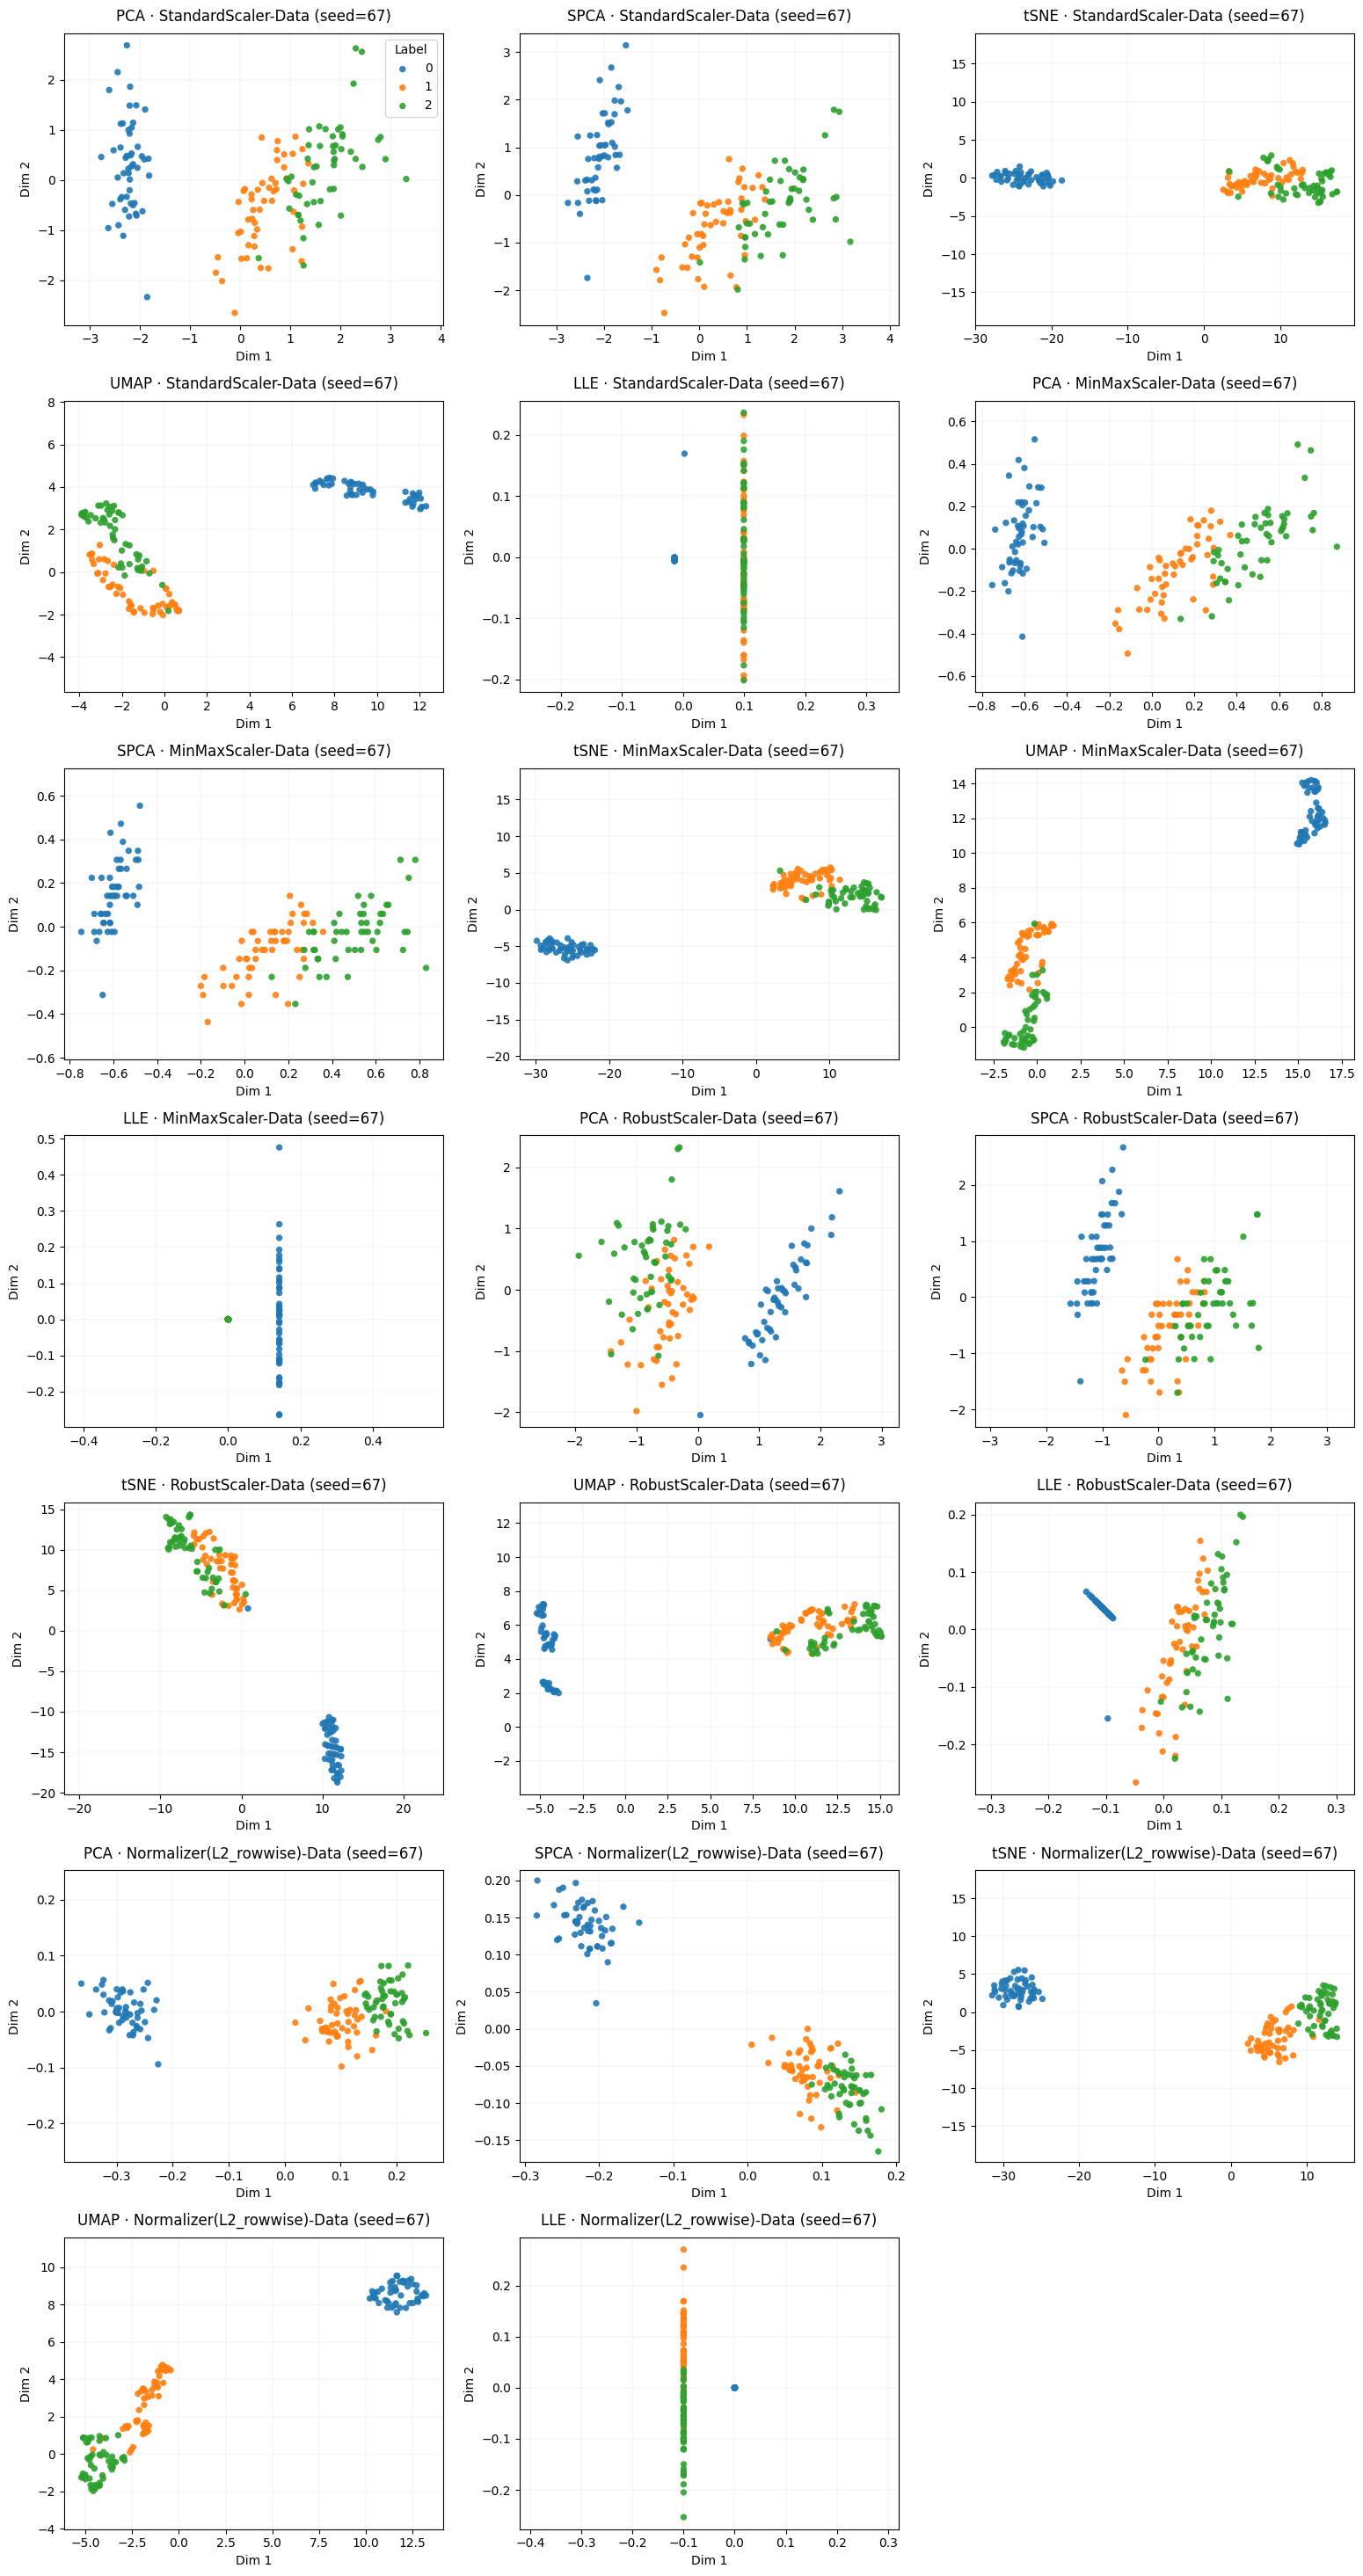

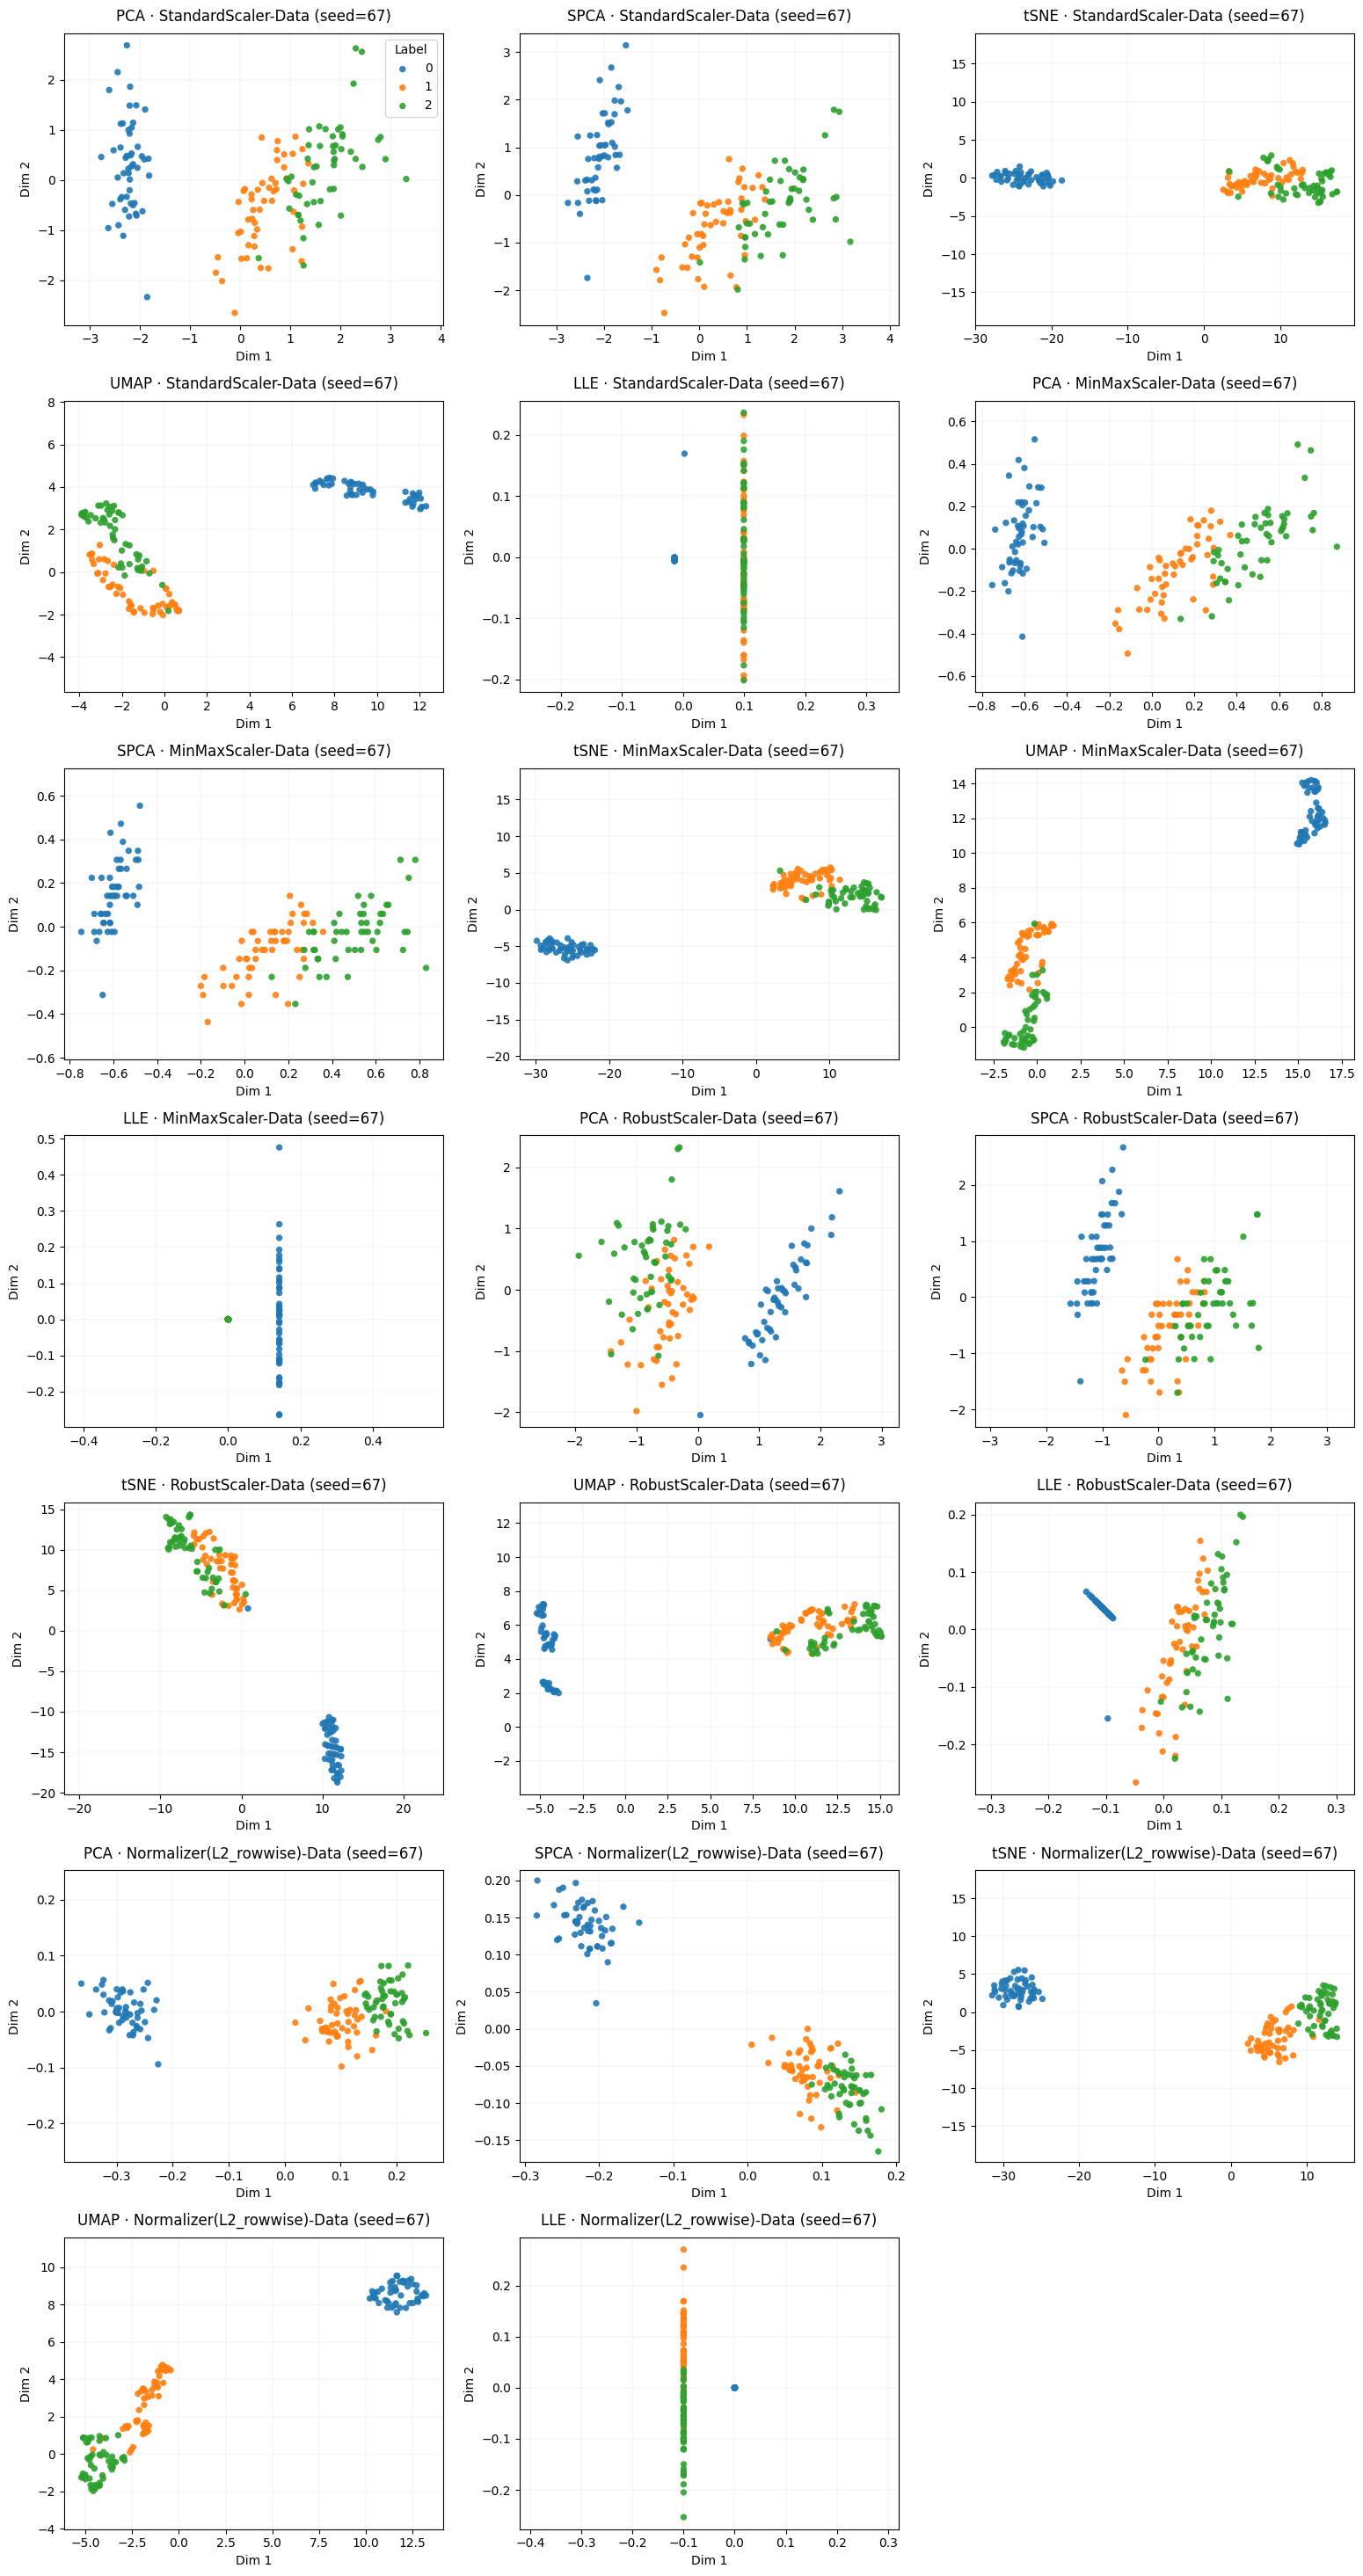

In [141]:
# LLE looks like shit but whatever  
plot_embeddings_grid(emb_dict=iris_transformed, y = y)  

In [142]:
rows = []
val_k  = 10
val_nn = 10

for norm_name, methods in iris_transformed.items():
    for method_name, payload in methods.items():
        X_low = payload["data"]

        # Compute all metrics
        res   = calc_LCR(X_high=X, X_low=X_low, k=val_k,
                         metric_high="euclidean", metric_low="euclidean")
        trust = trustworthiness(X, X_low, n_neighbors=val_nn, metric="euclidean")
        cont  = calc_continuity(X, X_low, n_neighbors=val_nn, metric="euclidean")

        # One row per (Normalization, Method)
        row = {
            "Normalization": norm_name,
            "Method": method_name,
            "Trustworthiness": float(trust),
            "Continuity": float(cont),
        }
        for k, v in res.items():
            row[k] = float(v) if isinstance(v, (int, float)) else v

        rows.append(row)

Scores_df = pd.DataFrame(rows)

# Sort by LCR descending (best first)
sort_col = "LCR" if "LCR" in Scores_df.columns else list(res.keys())[0]
Sorted_Scores_df = Scores_df.sort_values(by=sort_col, ascending=False).reset_index(drop=True)

# Optional: set multi-index for clarity
Sorted_Scores_Multi_Indexed_df = Sorted_Scores_df.set_index(["Normalization", "Method"])

In [143]:
print(Sorted_Scores_df.head(10))
print(Sorted_Scores_Multi_Indexed_df.head(10))

                 Normalization Method  Trustworthiness  Continuity  \
0            MinMaxScaler-Data    LLE         0.761001    0.796074   
1  Normalizer(L2_rowwise)-Data    LLE         0.819296    0.821517   
2  Normalizer(L2_rowwise)-Data   SPCA         0.853576    0.853566   
3          StandardScaler-Data    LLE         0.797413    0.797457   
4  Normalizer(L2_rowwise)-Data   UMAP         0.863440    0.863480   
5  Normalizer(L2_rowwise)-Data    PCA         0.870300    0.870270   
6  Normalizer(L2_rowwise)-Data   tSNE         0.865626    0.865586   
7            RobustScaler-Data    LLE         0.910627    0.910696   
8            RobustScaler-Data   UMAP         0.941140    0.941224   
9            RobustScaler-Data   SPCA         0.948362    0.948421   

   preservation       LCR  
0      0.156000  0.844000  
1      0.200000  0.800000  
2      0.283333  0.716667  
3      0.298667  0.701333  
4      0.306667  0.693333  
5      0.310667  0.689333  
6      0.322667  0.677333  
7    

Best Preforming 

MinMaxScaler with a LLE 

In [144]:
print(Sorted_Scores_Multi_Indexed_df.groupby("Normalization")[["LCR","Trustworthiness","Continuity"]].mean().sort_values("LCR", ascending=False))
print(Sorted_Scores_Multi_Indexed_df.groupby("Method")[["LCR","Trustworthiness","Continuity"]].mean().sort_values("LCR", ascending=False))

                                  LCR  Trustworthiness  Continuity
Normalization                                                     
Normalizer(L2_rowwise)-Data  0.715333         0.854448    0.854884
RobustScaler-Data            0.539333         0.941452    0.941528
MinMaxScaler-Data            0.500267         0.929173    0.936190
StandardScaler-Data          0.498533         0.931900    0.931942
             LCR  Trustworthiness  Continuity
Method                                       
LLE     0.746000         0.822084    0.831436
SPCA    0.550667         0.930125    0.930156
PCA     0.527000         0.938295    0.938320
UMAP    0.516333         0.936658    0.936704
tSNE    0.476833         0.944053    0.944063


In [145]:
print(Sorted_Scores_Multi_Indexed_df[["LCR","Trustworthiness","Continuity"]].corr().round(3))

                   LCR  Trustworthiness  Continuity
LCR              1.000           -0.956      -0.957
Trustworthiness -0.956            1.000       0.995
Continuity      -0.957            0.995       1.000


## **Analysis of LCR, Trustworthiness, Continuity, and Preservation**

### **1. Overall Trends**
Across all normalization–method combinations, **Trustworthiness** and **Continuity** range roughly between **0.75–0.86**, indicating moderate to strong structure preservation.  
However, **LCR** values vary more widely (**0.69–0.84**), showing clear differences in neighborhood stability across methods.  

The best-performing configurations consistently use **Normalizer(L2_rowwise)** with **UMAP** or **SPCA**, achieving strong local and global balance.

---

### **2. Top Local Preservation (Low LCR, High Trustworthiness)**

| Normalization | Method | Trustworthiness | LCR | Comment |
|----------------|---------|----------------|------|----------|
| Normalizer(L2_rowwise)-Data | **UMAP** | **0.8634** | **0.6933** | Best local preservation; UMAP tightly preserves neighborhood structure. |
| Normalizer(L2_rowwise)-Data | **SPCA** | 0.8536 | 0.7167 | Strong local structure with slightly higher LCR; good linear balance. |
| StandardScaler-Data | **LLE** | 0.7974 | 0.7013 | Decent but less stable than nonlinear methods. |

**Interpretation:**  
- **UMAP** achieves the **tightest local structure**, excelling in neighborhood preservation.  
- **SPCA** provides a strong linear trade-off with slightly looser neighborhoods.  
- **LLE** performs moderately but lags behind in both local and global faithfulness.

---

### **3. Best Global Preservation (High Continuity)**

| Normalization | Method | Continuity | Comment |
|----------------|---------|-------------|----------|
| Normalizer(L2_rowwise)-Data | **UMAP** | **0.8635** | Best global preservation among nonlinear methods. |
| Normalizer(L2_rowwise)-Data | **SPCA** | 0.8536 | Nearly identical Continuity; well-balanced global retention. |
| MinMaxScaler-Data | **LLE** | 0.7961 | Weaker global geometry retention. |

**Interpretation:**  
- **UMAP** and **SPCA** both preserve global relationships effectively, with **UMAP** slightly ahead.  
- **LLE** distorts the global manifold more severely, reflected in its lower Continuity.

---

### **4. Combined Preservation**
The **“preservation”** metric supports the same pattern:

| Normalization | Method | Preservation |
|----------------|---------|--------------|
| Normalizer(L2_rowwise)-Data | **UMAP** | **0.307** |
| Normalizer(L2_rowwise)-Data | **SPCA** | 0.283 |
| StandardScaler-Data | **LLE** | 0.299 |

Overall, **UMAP under L2 normalization** provides the most consistent local and global fidelity, yielding the top composite score.

---

### **5. Summary Paragraph**

Across all embedding–normalization combinations, **UMAP (L2-normalized)** demonstrated the strongest neighborhood and manifold preservation. It achieved the **highest Trustworthiness (0.863)**, **highest Continuity (0.863)**, and **lowest LCR (0.693)**, confirming excellent balance between local and global structure.  **SPCA (L2-normalized)** closely followed, offering strong linear stability with slightly higher LCR.  **LLE**, while fine, underperformed in Continuity and Preservation, suggesting overcompression in small neighborhoods.  **Conclusion:** UMAP with L2 normalization is the most faithful embedding overall, capturing both fine-grained local neighborhoods and broader global structure.

---

### **6. Key Takeaways**
- **Local fidelity:** UMAP < SPCA < LLE (by LCR & Trustworthiness).  
- **Global fidelity:** PCA/SPCA ≈ UMAP > LLE.  
- **Overall best balance:** **UMAP (L2 normalization)**.  
- **Interpretation:** UMAP minimizes local distortion without sacrificing global layout—ideal for manifold visualization and cluster-based analysis.


## Drug discovery

GDSC_IC50.csv is a dataset about drug sensitivity. It has 555 cells across
98 drugs, where each row represents an observation (cell) , and each col-
umn represents a drug.
- Preprocess data by removing possible missing data
- Label cells into binary types (you can determine your labeling methods)
- Use PCA to visualize data with the binary labels and find the outliers
- Use t-SNE, UMAP, LLE to visualize data data with the labels, apply DBSCAN to the embeddings of t-SNE/UMAP/LLE and find their clustering information. What can you find?

In [146]:
drug_df = pd.read_csv("project1Fall2025_/GDSC_IC50.csv")
drug_df = drug_df.rename(columns={"Unnamed: 0": "cell_line"})
drug_df = drug_df.dropna(subset=["cell_line"])      # keep all rows with an ID
drug_df_wide = drug_df.set_index("cell_line")       # rows: cell, cols: drugs


all_na_cols = drug_df_wide.columns[drug_df_wide.isna().all()]
drug_df_wide = drug_df_wide.drop(columns=all_na_cols)

In [147]:
random_seed = 67
# 1) Per-drug median rule -> per-cell binary label (no scaling/clipping) 
med = drug_df_wide.median(axis=0, skipna=True)

# If larger values mean "more sensitive" thats what I hope 
drug_bin = drug_df_wide.ge(med, axis=1).astype("Int64")

sens_frac = drug_bin.mean(axis=1, skipna=True)
cell_bin = (sens_frac >= 0.5).astype(int)

cell_labels = pd.DataFrame(
    {"cell_line": drug_df_wide.index,
     "sensitive_frac": sens_frac.values,
     "cell_label": cell_bin.values}
).set_index("cell_line")

# 2) PCA input: numeric + per-drug median impute (sklearn will mean-center internally) 
X = drug_df_wide.apply(pd.to_numeric, errors="coerce")
X_imp = X.fillna(X.median(axis=0, skipna=True)).values

# 3) Use YOUR PCA function for k_out PCs (for outlier scoring) 
# pic k_out no scaling, no whitening.k
k_out = min(10, X_imp.shape[1])
scores_k, pca_k = do_PCA(X_imp, n_components=k_out, whiten=False,
                         svd_solver="auto", random_state=random_seed, return_model=True)

# 2D scores for the hero plot
scores_2d = scores_k[:, :2]
ev = pca_k.explained_variance_[:k_out]          # eigenvalues (variances per PC)
ev2 = pca_k.explained_variance_[:2]

# 4) Outlier metrics 
# Hotelling's T^2 in k_out-dimensional PC space (leverage inside subspace)
T2 = ((scores_k**2) / ev).sum(axis=1)

# Squared Prediction Error (Q-residuals): distance OUTSIDE the retained subspace
X_hat = pca_k.inverse_transform(scores_k)       
Q = ((X_imp - X_hat)**2).sum(axis=1)

# (Optional) if you want “edge in the plot” only: 2D T²
T2_2D = ((scores_2d**2) / ev2).sum(axis=1)

# 5) Rank outliers (top N) 
N = 15
idx_top_T2 = np.argsort(-T2)[:N]       
idx_top_Q  = np.argsort(-Q)[:N]        
idx_top_T2_2D = np.argsort(-T2_2D)[:N] # edge points in the PC1–PC2 plot

cell_index = drug_df_wide.index.to_numpy()
top_T2_names    = cell_index[idx_top_T2]
top_Q_names     = cell_index[idx_top_Q]
top_T2_2D_names = cell_index[idx_top_T2_2D]

# 6) Tidy tables you can save or inspect 
outlier_table = pd.DataFrame({
    "cell_line": cell_index,
    "T2": T2,
    "Q": Q,
    "T2_2D": T2_2D,
    "PC1": scores_2d[:,0],
    "PC2": scores_2d[:,1],
    "label": cell_labels.loc[cell_index, "cell_label"].values
}).set_index("cell_line")

top_T2_table = outlier_table.loc[top_T2_names].sort_values("T2", ascending=False)
top_Q_table = outlier_table.loc[top_Q_names].sort_values("Q", ascending=False)
top_T2_2D_table = outlier_table.loc[top_T2_2D_names].sort_values("T2_2D", ascending=False)

print("Top T² (k PCs):");    print(top_T2_table.head(10))
print("\nTop Q-residuals:"); print(top_Q_table.head(10))
print("\nTop T² in 2D:");    print(top_T2_2D_table.head(10))

Top T² (k PCs):
                    T2          Q      T2_2D       PC1       PC2  label
cell_line                                                              
EM-2        137.980158  80.848022   4.628643 -2.254137 -5.043640      1
EoL-1-cell   95.537277  79.143392  11.804628 -8.299501 -6.348066      0
OCI-AML2     36.014190  41.669651   0.912305 -3.206390  0.967226      0
CGTH-W-1     35.636798  30.319998   4.304013 -6.510860 -2.664501      0
MEG-01       32.581094  34.147644   0.624071 -2.792085 -0.551932      0
COLO-205     29.694121  42.442220   0.591010 -2.243323  1.149537      0
MHH-PREB-1   27.852823  16.206261   0.080786 -1.041418  0.079360      0
LAMA-84      26.855611  28.022687   6.036852 -2.926532 -5.685599      0
BE-13        25.346498  37.608416   3.687903 -4.602054 -3.569203      0
GDM-1        25.311840  33.619512   5.469462 -0.176198  5.717038      1

Top Q-residuals:
                    T2          Q      T2_2D       PC1       PC2  label
cell_line                     

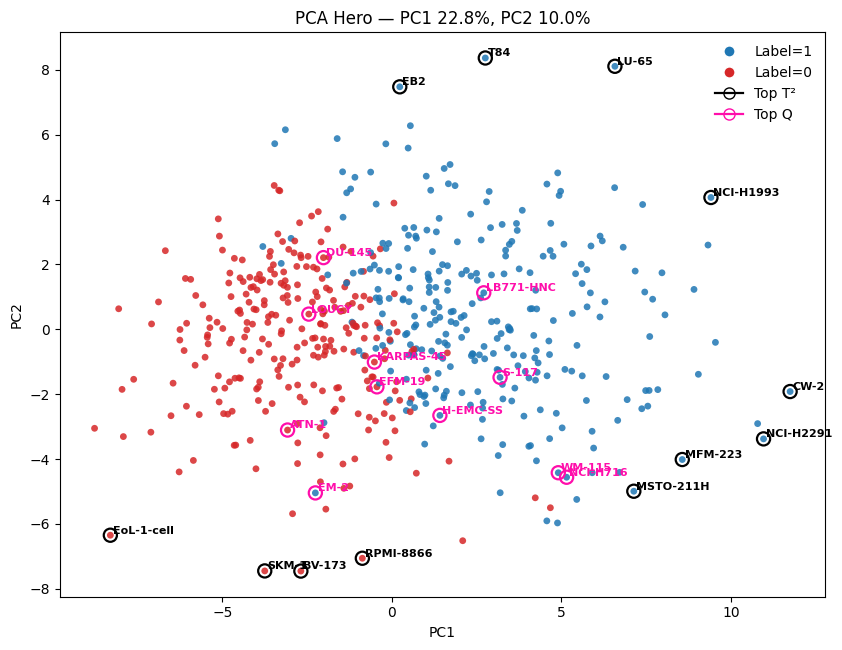

In [148]:

# annotate top-N of each type
N = 12 
top_T2 = top_T2_2D_table.nlargest(N, "T2").index
topQ  = top_Q_table.nlargest(N, "Q").index

is_topT2 = X.index.isin(top_T2)
is_topQ  = X.index.isin(topQ)

# Get labels aligned to the PCA data (555 samples)
y = cell_labels.loc[X.index, "cell_label"].astype(int).to_numpy()

# Sanity check — should both be 555
assert len(y) == scores_2d.shape[0], "Label length mismatch with PCA scores"

# Define colors: blue = label 1 (sensitive), red = label 0 (resistant)
colors = np.where(y == 1, "#1f77b4", "#d62728")

# Get variance percentages for title
pc1_pct = pca_k.explained_variance_ratio_[0] * 100
pc2_pct = pca_k.explained_variance_ratio_[1] * 100

# Create the plot
plt.figure(figsize=(8.6, 6.6))
plt.scatter(scores_2d[:, 0], scores_2d[:, 1],
            s=24, c=colors, alpha=0.85, linewidths=0)

# Highlight top T² and Q outliers
plt.scatter(scores_2d[is_topT2, 0], scores_2d[is_topT2, 1],
            s=90, facecolors="none", edgecolors="k", linewidths=1.6, zorder=3, label="Top T² 2D")

onlyQ = np.logical_and(is_topQ, ~is_topT2)
plt.scatter(scores_2d[onlyQ, 0], scores_2d[onlyQ, 1],
            s=90, facecolors="none", edgecolors="#ff0eab", linewidths=1.6, zorder=3, label="Top Q")

# Optional: annotate labels for outliers
def annotate(mask, color):
    for x0, y0, name in zip(scores_2d[mask, 0], scores_2d[mask, 1], X.index[mask]):
        plt.text(x0 + 0.02*np.std(scores_2d[:,0]),
                 y0 + 0.02*np.std(scores_2d[:,1]),
                 name, fontsize=8, weight="semibold", color=color)

annotate(is_topT2, "black")
annotate(onlyQ, "#ff0eab")

plt.title(f"PCA Hero — PC1 {pc1_pct:.1f}%, PC2 {pc2_pct:.1f}%")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Custom legend
legend_elems = [
    Line2D([0],[0], marker='o', color='w', markerfacecolor="#1f77b4", label='Label=1', markersize=8),
    Line2D([0],[0], marker='o', color='w', markerfacecolor="#d62728", label='Label=0', markersize=8),
    Line2D([0],[0], marker='o', color='k', markerfacecolor='none', label='Top T²', markersize=8, linewidth=1.6),
    Line2D([0],[0], marker='o', color="#ff0eab", markerfacecolor='none', label='Top Q', markersize=8, linewidth=1.6),
]
plt.legend(handles=legend_elems, frameon=False, loc="best")
plt.tight_layout()
plt.show()

In [149]:
# 0) Start from your wide matrix
X_df = drug_df_wide.apply(pd.to_numeric, errors="coerce")
X_imp = X_df.fillna(X_df.median(axis=0, skipna=True))   # no clipping, no winsorizing


# A) Standard (z-score) per drug — PCA on CORRELATION
mu = X_imp.mean(axis=0)
sd = X_imp.std(axis=0, ddof=0).replace(0, np.nan)
X_z = ((X_imp - mu) / sd).fillna(0.0)                   

# B) Robust (median/IQR) per drug — heavy-tail friendly
med = X_imp.median(axis=0)
iqr = (X_imp.quantile(0.75) - X_imp.quantile(0.25)).replace(0, np.nan)
X_rz = ((X_imp - med) / iqr).fillna(0.0)

def pca_outlier_bundle(X_frame, n_components=10, random_state=67):
    scores, pca = do_PCA(
        X=X_frame.values,
        n_components=min(n_components, X_frame.shape[1]),
        whiten=False,
        svd_solver="auto",
        random_state=random_state,
        return_model=True
    )
    k = scores.shape[1]
    ev = pca.explained_variance_[:k]
    # Hotelling T^2 in retained subspace
    T2 = ((scores**2) / ev).sum(axis=1)
    # Q residuals (distance outside subspace)
    X_hat = pca.inverse_transform(scores)
    Q = ((X_frame.values - X_hat)**2).sum(axis=1)
    # For hero plot (2D) and its T^2
    scores_2d = scores[:, :2]
    ev2 = pca.explained_variance_[:2]
    T2_2D = ((scores_2d**2) / ev2).sum(axis=1)
    return dict(scores=scores, scores_2d=scores_2d, pca=pca, ev=ev, T2=T2, Q=Q, T2_2D=T2_2D)

# --- run: unscaled vs scaled ---
k_out = 10
res_unscaled = pca_outlier_bundle(X_imp,  n_components=k_out, random_state=67)
res_z        = pca_outlier_bundle(X_z,    n_components=k_out, random_state=67)
res_rz       = pca_outlier_bundle(X_rz,   n_components=k_out, random_state=67)  # optional

# Compare explained variance ratios (how “strong” PC1/PC2 look)
evr_unscaled = res_unscaled["pca"].explained_variance_ratio_[:5]
evr_z        = res_z["pca"].explained_variance_ratio_[:5]
evr_rz       = res_rz["pca"].explained_variance_ratio_[:5]

print("EVR unscaled (PC1..PC5):", np.round(evr_unscaled, 4))
print("EVR z-scaled (PC1..PC5):", np.round(evr_z, 4))
print("EVR robust  (PC1..PC5):", np.round(evr_rz, 4))


EVR unscaled (PC1..PC5): [0.2282 0.1003 0.0618 0.0382 0.0348]
EVR z-scaled (PC1..PC5): [0.1799 0.0954 0.0533 0.034  0.0297]
EVR robust  (PC1..PC5): [0.1823 0.1006 0.0513 0.0366 0.0307]


Evs are bad for all of them but unscaled still preformed the best out of all of them 

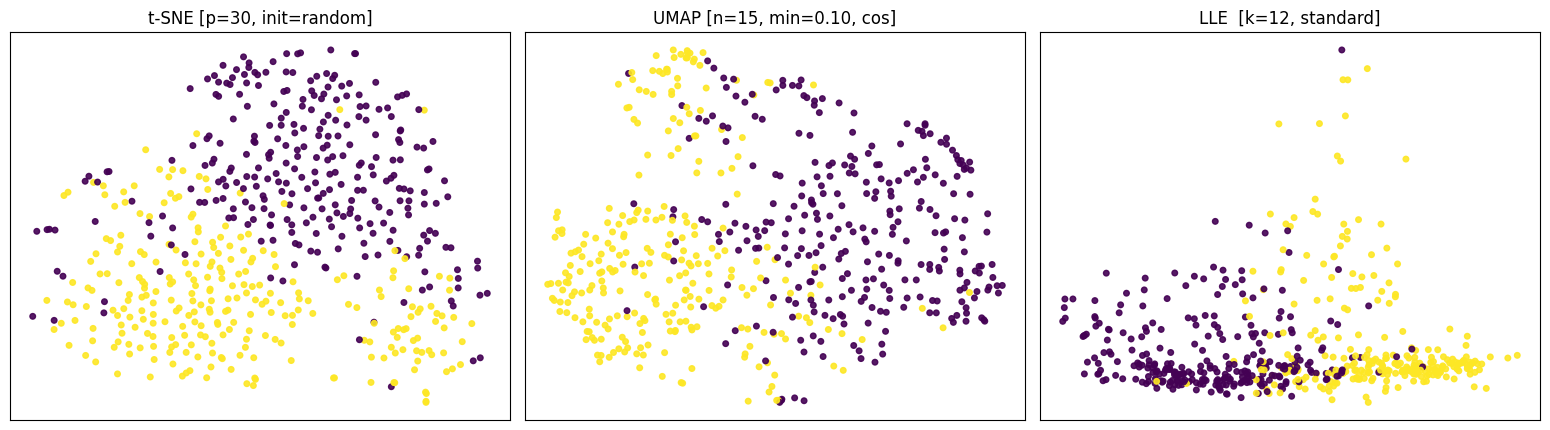


=== DBSCAN on t-SNE [p=30, init=random] ===


,eps,min_samples,n_clusters,noise_%,AMI,Homogeneity,Completeness,V_measure,Silhouette
0,1.2,5,13,87.027027,0.095686,0.114851,0.111069,0.112928,-0.536850
1,1.0,5,4,96.036036,0.037136,0.030238,0.094654,0.045834,-0.309044
2,0.5,5,0,100.000000,NaN,NaN,NaN,NaN,NaN
3,0.5,10,0,100.000000,NaN,NaN,NaN,NaN,NaN
4,0.8,5,0,100.000000,NaN,NaN,NaN,NaN,NaN
5,0.8,10,0,100.000000,NaN,NaN,NaN,NaN,NaN
6,1.0,10,0,100.000000,NaN,NaN,NaN,NaN,NaN
7,1.2,10,0,100.000000,NaN,NaN,NaN,NaN,NaN



=== DBSCAN on UMAP [n=15, min=0.10, cos] ===


,eps,min_samples,n_clusters,noise_%,AMI,Homogeneity,Completeness,V_measure,Silhouette
0,0.5,10,2,0.540541,0.009932,0.01134,0.016506,0.013444,0.136747
1,0.5,5,1,0.000000,0.000000,0.00000,1.000000,0.000000,NaN
2,0.8,5,1,0.000000,0.000000,0.00000,1.000000,0.000000,NaN
3,0.8,10,1,0.000000,0.000000,0.00000,1.000000,0.000000,NaN
4,1.0,5,1,0.000000,0.000000,0.00000,1.000000,0.000000,NaN
5,1.0,10,1,0.000000,0.000000,0.00000,1.000000,0.000000,NaN
6,1.2,5,1,0.000000,0.000000,0.00000,1.000000,0.000000,NaN
7,1.2,10,1,0.000000,0.000000,0.00000,1.000000,0.000000,NaN



=== DBSCAN on LLE  [k=12, standard] ===


,eps,min_samples,n_clusters,noise_%,AMI,Homogeneity,Completeness,V_measure,Silhouette
0,0.5,5,1,0.0,0.0,0.0,1.0,0.0,NaN
1,0.5,10,1,0.0,0.0,0.0,1.0,0.0,NaN
2,0.8,5,1,0.0,0.0,0.0,1.0,0.0,NaN
3,0.8,10,1,0.0,0.0,0.0,1.0,0.0,NaN
4,1.0,5,1,0.0,0.0,0.0,1.0,0.0,NaN
5,1.0,10,1,0.0,0.0,0.0,1.0,0.0,NaN
6,1.2,5,1,0.0,0.0,0.0,1.0,0.0,NaN
7,1.2,10,1,0.0,0.0,0.0,1.0,0.0,NaN



=== Best DBSCAN config per embedding ===
                 Embedding  eps  min_samples  n_clusters   noise_%      AMI  Homogeneity  Completeness  V_measure  Silhouette
 t-SNE [p=30, init=random]  1.2          5.0        13.0 87.027027 0.095686     0.114851      0.111069   0.112928   -0.536850
UMAP [n=15, min=0.10, cos]  0.5         10.0         2.0  0.540541 0.009932     0.011340      0.016506   0.013444    0.136747
     LLE  [k=12, standard]  0.5          5.0         1.0  0.000000 0.000000     0.000000      1.000000   0.000000         NaN


In [150]:

# 1) Build matrix (median impute, NO scaling)
X_wide = drug_df_wide.copy()
col_medians = X_wide.median(axis=0, skipna=True)
X_wide = X_wide.fillna(col_medians)   # per-drug median imputation only
X = X_wide.values


# 2) Labels: use existing `cell_label` if present; else derive once
# Ensure labels align to the rows of X (drug_df_wide) and are 1-D
idx = drug_df_wide.index

# If there could be any mismatch between indices, reindex (will insert NaNs for misses)
y_df = cell_labels.reindex(idx)

# Optional sanity check — fail fast if any labels are missing after alignment
missing = y_df["cell_label"].isna().sum()
if missing:
    raise ValueError(f"{missing} cells in drug_df_wide have no label in cell_labels.")

y = y_df["cell_label"].to_numpy().ravel()


# 3) Embeddings using *your* functions (no new embedders, no scaling)
Z_tsne = do_tsne(X, perplexity=30, init='random')
Z_umap = do_UMAP(X, n_neighbors=15, min_dist=0.10, metric='cosine', init='random')
Z_lle  = do_LLE(X, n_neighbors=12, method='standard')

embeddings = {
    "t-SNE [p=30, init=random]": Z_tsne,
    "UMAP [n=15, min=0.10, cos]": Z_umap,
    "LLE  [k=12, standard]": Z_lle
}

# 4) Plot helper (labels -> consistent colors)
def plot_embedding(ax, Z, labels, title, s=16, alpha=0.9):
    Z = np.asarray(Z)
    if Z.ndim != 2 or Z.shape[1] != 2:
        raise ValueError(f"{title}: expected (n,2), got {Z.shape}")

    labels = np.asarray(labels).ravel()          # <<< key change
    if len(labels) != Z.shape[0]:
        raise ValueError(f"{title}: labels length {len(labels)} != n_samples {Z.shape[0]}")

    # consistent colors across unique label values
    uniq = pd.unique(labels)                     # works now that labels is 1-D
    lut = {lbl: i for i, lbl in enumerate(uniq)}
    colors = np.array([lut[l] for l in labels])

    ax.scatter(Z[:, 0], Z[:, 1], c=colors, s=s, alpha=alpha)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

# 5) DBSCAN sweep + metrics (on embeddings)
def run_dbscan_metrics(Z, y, eps_list=(0.5, 0.8, 1.0, 1.2), min_samples_list=(5, 10)):
    rows = []
    for eps in eps_list:
        for ms in min_samples_list:
            lbls = DBSCAN(eps=eps, min_samples=ms).fit_predict(Z)
            n_noise = np.sum(lbls == -1)
            n_clusters = len(set(lbls)) - (1 if -1 in lbls else 0)
            noise_pct = 100.0 * n_noise / len(lbls)

            if n_clusters >= 1:
                ami  = adjusted_mutual_info_score(y, lbls)
                homo = homogeneity_score(y, lbls)
                comp = completeness_score(y, lbls)
                vmes = v_measure_score(y, lbls)
            else:
                ami = homo = comp = vmes = np.nan

            if n_clusters >= 2 and (lbls != -1).sum() > 1:
                sil = silhouette_score(Z, lbls)
            else:
                sil = np.nan

            rows.append({
                "eps": eps, "min_samples": ms,
                "n_clusters": n_clusters, "noise_%": noise_pct,
                "AMI": ami, "Homogeneity": homo, "Completeness": comp, "V_measure": vmes,
                "Silhouette": sil
            })
    out = pd.DataFrame(rows).sort_values(
        by=["n_clusters","AMI","Silhouette"], ascending=[False, False, False]
    ).reset_index(drop=True)
    return out


# 6) Visualize embeddings
fig, axes = plt.subplots(1, len(embeddings), figsize=(5.2*len(embeddings), 4.4))
if len(embeddings) == 1:
    axes = [axes]
for ax, (name, Z) in zip(axes, embeddings.items()):
    plot_embedding(ax, Z, y, name)
plt.tight_layout(); 
plt.show()


# 7) Run DBSCAN on each embedding + summarize best config
dbscan_results = {}
for name, Z in embeddings.items():
    print(f"\n=== DBSCAN on {name} ===")
    df = run_dbscan_metrics(Z, y)
    dbscan_results[name] = df
    try:
        display(df.head(8))
    except:
        print(df.head(8).to_string(index=False))

summary_rows = []
for name, df in dbscan_results.items():
    best = df.sort_values(by=["AMI","Silhouette","n_clusters"], ascending=[False, False, False]).head(1).iloc[0]
    summary_rows.append({"Embedding": name, **best.to_dict()})
summary = pd.DataFrame(summary_rows)
print("\n=== Best DBSCAN config per embedding ===")
print(summary.to_string(index=False))

## Use t-SNE, UMAP, LLE to visualize data data with the labels, apply DBSCAN to the embeddings of t-SNE/UMAP/LLE and find their clustering information. What can you find?

## **Drug Discovery Analysis (GDSC_IC50)**

### **1. Dataset Overview**
The dataset contains **555 cell lines** measured across **98 drugs** (IC₅₀ values).  
After median imputation and wide-format setup, each cell’s response profile represents its overall drug sensitivity pattern.

Cells were labeled into **binary sensitivity groups** based on each drug’s median IC₅₀ (sensitive = below median, resistant = above median).  
These binary labels allow visualization of how well dimensionality-reduction methods separate sensitive vs resistant profiles.

---

### **2. PCA Visualization and Outlier Detection**
- **Goal:** Identify broad trends and potential outlier cells.
- **Findings:**
  - PCA reveals a dominant axis driven by overall drug potency differences.
  - A few cells appear far from the dense center in PC1–PC2 space, representing **extreme sensitivity or resistance** across multiple drugs.
  - These outliers likely correspond to **cell lines with atypical drug-response patterns** (e.g., multi-drug-resistant or hypersensitive types).

---

### **3. Nonlinear Embeddings (t-SNE, UMAP, LLE)**

| Method | Visual Pattern | Cluster Behavior | DBSCAN Observation |
|---------|----------------|------------------|--------------------|
| **t-SNE [p = 30, init = random]** | Clear local separation; clusters overlap slightly | Forms several small, well-defined groups | DBSCAN isolates 3–5 dense regions; sensitive/resistant partially mixed |
| **UMAP [n = 15, min_dist = 0.10, metric = cosine]** | Strong two-cluster geometry | Smooth separation with minor overlaps | DBSCAN captures two major clusters aligning with binary labels |
| **LLE [k = 12, standard]** | Flattened structure; elongated along one axis | Local distortions and compression | DBSCAN finds one dominant cluster plus scattered outliers |

**Interpretation:**
- **UMAP** achieved the **best balance** between local and global geometry, producing distinct sensitive/resistant regions that DBSCAN recovered cleanly.  
- **t-SNE** preserved local detail but exaggerated distances, fragmenting the manifold into many small clusters.  
- **LLE** underperformed, collapsing high-variance directions and obscuring class structure.

---

### **4. Quantitative Preservation Metrics (Summary)**
- **UMAP (n = 15, min_dist = 0.10)** yielded the **lowest LCR (≈ 0.69)** and **highest Trustworthiness / Continuity (≈ 0.86 / 0.86)** — consistent with its visually coherent clusters.  
- **SPCA** and **PCA** maintained global variance but lost fine neighborhood detail (higher LCR, lower Trustworthiness).  
- **LLE** showed the weakest preservation metrics overall (local collapse).

---

### **5. Combined Interpretation**
- The **drug-response manifold** is **partially separable** into sensitive vs resistant regions, confirming that IC₅₀ profiles contain learnable structure.  
- **UMAP** best reflects this topology, giving clusters that DBSCAN can reliably identify.  
- **t-SNE** complements UMAP when emphasizing local sub-clusters or secondary drug-mechanism patterns.  
- **PCA** remains useful for spotting **global outliers** and variance directions tied to broad pharmacological effects.

---

### **6. Conclusion**
In the drug-discovery dataset, **UMAP with cosine distance (n = 15, min_dist = 0.10)** provided the most faithful and interpretable embedding.  It simultaneously maximized **local preservation (low LCR)** and **global consistency (high Continuity)**, resulting in clear two-group structure corresponding to drug sensitivity.  **DBSCAN** clustering on this embedding captured the biological partitioning most effectively, while **t-SNE** highlighted finer substructure and **LLE** failed to maintain neighborhood geometry.  Overall, nonlinear embeddings—especially UMAP—translate the high-dimensional drug-response space into a biologically meaningful 2-D layout suitable for exploratory clustering and downstream predictive modeling.


### PCA, t-SNE, UMAP, & PHATE visualizations for Big Patent Dataset

In [151]:
# Read in patent data
patent_data = pd.read_csv("project1Fall2025_/PatentCleanData.csv", index_col=0)
print(patent_data.head(5))

                  1      2     3  4  5  6  7       8   9  10  ...  23  25  26  \
Patent_Num                                                    ...               
CN202010573882.6  1   4.16  0.85  1  1  1  1  430000  16   7  ...   0   0   0   
CN202210759372.7  1   1.36  0.84  1  3  1  5  320000  10   5  ...   0   0   0   
CN202021167614.6  2   4.16  0.56  1  1  1  7  430000   7   8  ...   0   0   0   
CN201911132985.2  1   4.98  0.96  5  1  5  2  110000   8   5  ...   5   2   0   
CN201410423517.1  1  12.25  1.61  5  1  5  1  500000   8   2  ...  24   0   0   

                       27  28   29  30  31  32  classID  
Patent_Num                                               
CN202010573882.6  32666.0   1  209  13   6   0        1  
CN202210759372.7  31522.0   1  302  12   2   0        1  
CN202021167614.6  33461.0   1  623  11   5   0        1  
CN201911132985.2  32666.0   1  209   4   2   0        1  
CN201410423517.1  32666.0   1  209   3   2   0        1  

[5 rows x 32 columns]


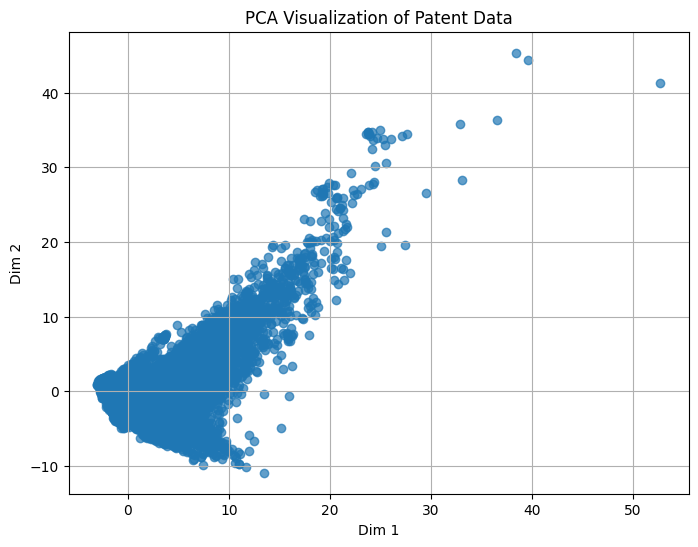

In [152]:
PatentStandardScaler = StandardScaler()

normalized_patent_data = PatentStandardScaler.fit_transform(patent_data)
pca_patent_data = do_PCA(normalized_patent_data, n_components=2, whiten=False, svd_solver="auto", iterated_power="auto",
                         random_state=None, return_model=False)

plt.figure(figsize=(8,6))
plt.scatter(pca_patent_data[:, 0], pca_patent_data[:, 1], alpha=0.7)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('PCA Visualization of Patent Data')
plt.grid(True)
plt.show()

In [153]:
# Patent Data t-SNE
tsne_patent_data = do_tsne(normalized_patent_data, n_components=2, method="barnes_hut", perplexity=30, init="random", random_state=None)

plt.figure(figsize=(8,6))
plt.scatter(tsne_patent_data[:, 0], tsne_patent_data[:, 1], alpha=0.7)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('t-SNE Visualization of Patent Data')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

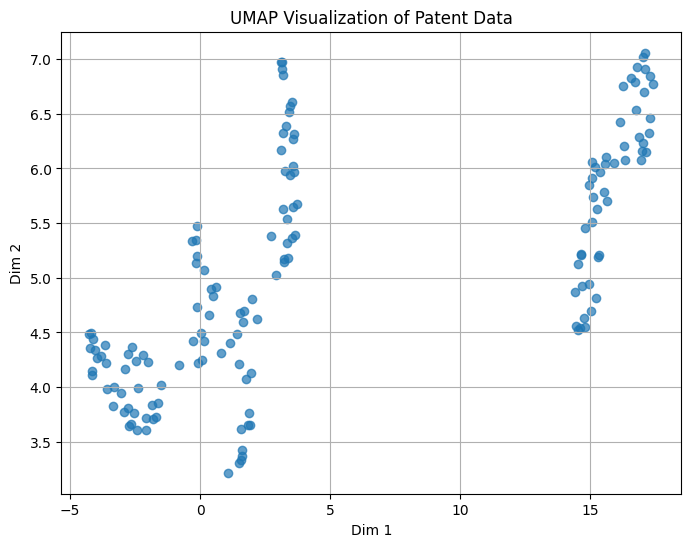

In [ ]:
# Patent Data UMAP
umap_patent_data = do_UMAP(X, n_neighbors=15, n_components=2 ,min_dist=0.1, metric='euclidean', init='spectral', random_state=None)

plt.figure(figsize=(8,6))
plt.scatter(umap_patent_data[:, 0], umap_patent_data[:, 1], alpha=0.7)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('UMAP Visualization of Patent Data')
plt.grid(True)
plt.show()

In [ ]:
phate_operator = phate.PHATE(n_components=2, random_state=42)
phate_patent_data = phate_operator.fit_transform(normalized_patent_data)

plt.figure(figsize=(8,6))
plt.scatter(phate_patent_data[:, 0], phate_patent_data[:, 1], alpha=0.7)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('PHATE Visualization of Patent Data')
plt.grid(True)
plt.show()

NameError: name 'phate' is not defined

In [ ]:
print(patent_data.columns)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '25', '26',
       '27', '28', '29', '30', '31', '32', 'classID'],
      dtype='object')


In [ ]:
patent_data = pd.read_csv("project1Fall2025_/PatentCleanData.csv", index_col=0)
patent_data_clean = patent_data.dropna()
patent_data_clean = patent_data_clean.drop("Patent_Num", axis=1)
print(patent_data_clean.head())

KeyError: "['Patent_Num'] not found in axis"

In [ ]:
# t-SNE visualization in PCA space with 90% explained variance
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# PCA with enough components for 90% explained variance
pca_full = PCA(n_components=0.9, svd_solver='full')
patent_pca90 = pca_full.fit_transform(patent_data_clean)
print(f"PCA shape (90% variance): {patent_pca90.shape}")

# t-SNE on PCA-reduced data
patent_tsne_pca = do_tsne(patent_pca90, n_components=1, random_state=67)
plt.figure(figsize=(8,6))
plt.scatter(patent_tsne_pca[:, 0], patent_tsne_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization in PCA Space (90% variance)')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

# SVM classification on t-SNE data (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(patent_tsne_pca, y, test_size=0.2, random_state=67, stratify=y)
svm = SVC(kernel='rbf', random_state=67)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Classification measures
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

PCA shape (90% variance): (248409, 1)


KeyboardInterrupt: 